In [1]:
!pip install segmentation-models-pytorch --quiet
!pip install -U git+https://github.com/albumentations-team/albumentations --quiet.
!pip install --upgrade opencv-contrib-python --quiet
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.6 MB/s eta 0:00:00

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --quiet.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 9.8 MB/s eta 0:00:00


Imports


In [2]:
import os
import torch
import cv2
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
images_list = os.listdir('/content/drive/MyDrive/chest_segmentation dataset/image')
masks_list = os.listdir('/content/drive/MyDrive/chest_segmentation dataset/mask')
print(f'No of images is {len(images_list)}')
print(f'No of masks is {len(masks_list)}')

No of images is 5226
No of masks is 5226


In [4]:
images_new = []
masks_new = []
number_of_images = 2000
root = '/content/drive/MyDrive/chest_segmentation dataset'
not_present = []
for i in range(number_of_images):
  filename = masks_list[i]
  filename1 = filename
  filename1 = filename1.replace("masked","chest")
  filename1 = filename1.replace("jpeg","png")
  if filename1 in images_list:
    input_file = os.path.join(root,'image',filename1)
    target_file = os.path.join(root,'mask',filename)
    images_new.append(input_file)
    masks_new.append(target_file)
  if filename1 not in images_list:
    not_present.append(filename)
print(f'Mask present but corresponding image not present: {len(not_present)}')

Mask present but corresponding image not present: 10


In [5]:
dict = {'masks': masks_new, 'images': images_new}
df = pd.DataFrame(dict)
df.to_csv('train.csv')

In [6]:
df.shape

(1990, 2)

Hyperparameters

In [7]:
IMG_SIZE = 320
epochs = 10
lr = 0.001
BATCH_SIZE = 16
ENCODER = 'resnet50'
WEIGHTS = 'imagenet'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
df = pd.read_csv('/content/train.csv')

In [9]:
train_df,test_val_df = train_test_split(df,test_size=0.3,random_state=42)
train_df.head()

,Unnamed: 0,masks,images
575,575,/content/drive/MyDrive/chest_segmentation data...,/content/drive/MyDrive/chest_segmentation data...
557,557,/content/drive/MyDrive/chest_segmentation data...,/content/drive/MyDrive/chest_segmentation data...
693,693,/content/drive/MyDrive/chest_segmentation data...,/content/drive/MyDrive/chest_segmentation data...
1151,1151,/content/drive/MyDrive/chest_segmentation data...,/content/drive/MyDrive/chest_segmentation data...
1340,1340,/content/drive/MyDrive/chest_segmentation data...,/content/drive/MyDrive/chest_segmentation data...


In [10]:
test_df,val_df = train_test_split(test_val_df,test_size=0.5,random_state=42)
test_df.head()

,Unnamed: 0,masks,images
1979,1979,/content/drive/MyDrive/chest_segmentation data...,/content/drive/MyDrive/chest_segmentation data...
583,583,/content/drive/MyDrive/chest_segmentation data...,/content/drive/MyDrive/chest_segmentation data...
798,798,/content/drive/MyDrive/chest_segmentation data...,/content/drive/MyDrive/chest_segmentation data...
1565,1565,/content/drive/MyDrive/chest_segmentation data...,/content/drive/MyDrive/chest_segmentation data...
1232,1232,/content/drive/MyDrive/chest_segmentation data...,/content/drive/MyDrive/chest_segmentation data...


In [11]:
row = train_df.iloc[13]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.COLOR_BGR2RGB)

In [12]:
type(mask)

numpy.ndarray

In [13]:
image = cv2.imread('/content/drive/MyDrive/chest_segmentation dataset/mask/maskedImage_NORMAL0.jpeg')

num_channels = image.shape[2]

print("Number of channels in the image:", num_channels)

image.shape

Number of channels in the image: 3


(512, 512, 3)

In [14]:
import cv2

image = cv2.imread('/content/drive/MyDrive/covid/Data small/test/NORMAL/Copy of NORMAL(1265).jpg')

if image is not None:
    if image.shape[2] == 3:
        if image[0, 0, 0] == image[0, 0, 2]:
            print("The image is in BGR color space")
        else:
            print("The image is in RGB color space")
    else:
        print("The image is not in RGB or BGR color space")
else:
    print("Failed to load the image.")


The image is in BGR color space


In [15]:
image.shape

(967, 1171, 3)

Augmentation Functions

In [16]:
import albumentations as A

In [17]:
transform_train = A.Compose([
                  A.Resize(IMG_SIZE,IMG_SIZE),
                  A.HorizontalFlip(),
                  A.VerticalFlip()
                ],is_check_shapes=False)

transform_val = A.Compose([
                A.Resize(IMG_SIZE,IMG_SIZE),
              ],is_check_shapes=False)

transform_test = A.Compose([
                A.Resize(IMG_SIZE,IMG_SIZE),
              ],is_check_shapes=False)

Custom Dataset class

In [18]:
from torch.utils.data import Dataset,DataLoader

In [19]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations=None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask,axis=-1)

    if self.augmentations is not None:
      data = self.augmentations(image=image,mask=mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) /255.0)

    return image,mask

In [20]:
trainset = SegmentationDataset(train_df,transform_train)
validset = SegmentationDataset(val_df,transform_val)
testset = SegmentationDataset(test_df,transform_test)

In [21]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")
print(f"Size of testset : {len(testset)}")

Size of Trainset : 1393
Size of Validset : 299
Size of testset : 298


In [22]:
def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')




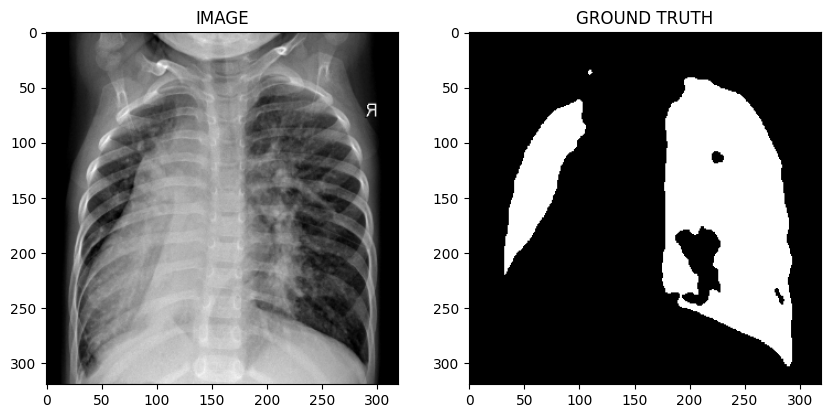

In [24]:
index = 8
img,msk = trainset[index]
show_image(img,msk)

In [25]:
img.shape

torch.Size([3, 320, 320])

Loading dataset into batches

In [26]:
trainloader = DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
valloader = DataLoader(validset,batch_size=BATCH_SIZE)
testloader = DataLoader(testset,batch_size=BATCH_SIZE)

In [27]:
print(f"Number of training batches = {len(trainloader)}")
print(f"Number of validation batches = {len(valloader)}")
print(f"Number of test batches = {len(testloader)}")

Number of training batches = 88
Number of validation batches = 19
Number of test batches = 19


In [28]:
it = iter(trainloader)
image,mask = next(it)

In [29]:
image.shape

torch.Size([16, 3, 320, 320])

In [30]:
mask.shape

torch.Size([16, 1, 320, 320])

In [31]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-xw7x3ddl
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-xw7x3ddl
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 6db76a1106426ac5b55f39fba68168f3bccae7f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 0.9.2
    Uninstalling timm-0.9.2:
      Successfully uninstalled timm-0.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
segmentation-models-pytorch 0.3.3 requires timm==0.9.2, but you have timm 0.9.7 which is incompatible.


Segmentation model

In [32]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [33]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arc = smp.Unet(encoder_name=ENCODER,
                        encoder_weights=WEIGHTS,
                        in_channels = 3,
                        classes = 1)

  def forward(self, image,mask=None):
    logits = self.arc(image)
    if mask is not None:
      loss1 = DiceLoss(mode='binary')(logits,mask)
      loss2 = nn.BCEWithLogitsLoss()(logits,mask)
      return logits,loss1+loss2

    return logits

In [34]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 291MB/s]


Create train and validation function

In [35]:
def train_fn(model,trainloader,optimizer):
  model.train()
  total_loss = 0.0

  for image,mask in tqdm(trainloader, desc="Training"):
    image = image.to(DEVICE)
    mask = mask.to(DEVICE)

    optimizer.zero_grad()
    logits ,loss = model(image,mask)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/ (len(trainloader))

In [36]:
def val_fn(model,valloader):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for image,mask in tqdm(valloader):
      image = image.to(DEVICE)
      mask = mask.to(DEVICE)

      _,loss = model(image,mask)

      total_loss += loss.item()

  return total_loss/ (len(valloader))

Model Training

In [37]:
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [38]:
def train_model(epochs,optimizer):
  best_val_loss = np.Inf
  for i in range(epochs):
    train_loss = train_fn(model,trainloader,optimizer)
    val_loss = val_fn(model,valloader)

    if val_loss < best_val_loss:
      torch.save(model.state_dict(),'/content/drive/MyDrive/Saved/bestseg.pt')
      print("SAVED MODEL")
      best_val_loss = val_loss

    print(f"Epoch: {i+1} training_loss: {train_loss} validation_loss: {val_loss}")

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
train_model(10,optimizer)

Testing

In [40]:
model_test = model.load_state_dict(torch.load('/content/drive/MyDrive/Saved/bestseg.pt'))


In [45]:
index = 46

# image,mask = validset[index]
image,mask = testset[index]

logits_mask = model(image.to(DEVICE).unsqueeze(0))

pred_mask = torch.sigmoid(logits_mask)

pred_mask = (pred_mask > 0.5) * 1.0

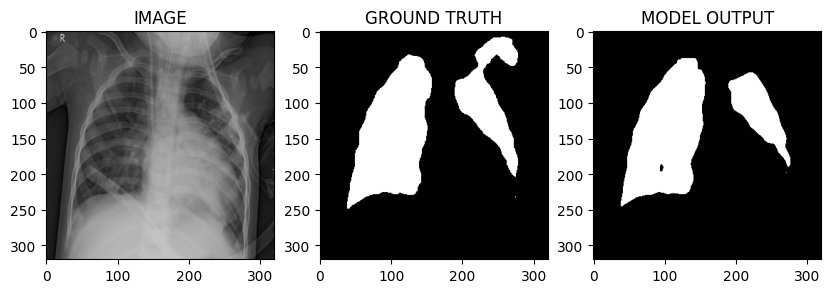

In [46]:
show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

In [48]:
image

tensor([[[0.1451, 0.1569, 0.1647,  ..., 0.0196, 0.0196, 0.0196],
         [0.1490, 0.1647, 0.1608,  ..., 0.0078, 0.0039, 0.0039],
         [0.1529, 0.1647, 0.1569,  ..., 0.0118, 0.0078, 0.0078],
         ...,
         [0.1176, 0.1176, 0.1176,  ..., 0.1176, 0.1176, 0.1176],
         [0.1176, 0.1176, 0.1137,  ..., 0.1176, 0.1176, 0.1176],
         [0.1176, 0.1176, 0.1137,  ..., 0.1176, 0.1176, 0.1176]],

        [[0.1451, 0.1569, 0.1647,  ..., 0.0196, 0.0196, 0.0196],
         [0.1490, 0.1647, 0.1608,  ..., 0.0078, 0.0039, 0.0039],
         [0.1529, 0.1647, 0.1569,  ..., 0.0118, 0.0078, 0.0078],
         ...,
         [0.1176, 0.1176, 0.1176,  ..., 0.1176, 0.1176, 0.1176],
         [0.1176, 0.1176, 0.1137,  ..., 0.1176, 0.1176, 0.1176],
         [0.1176, 0.1176, 0.1137,  ..., 0.1176, 0.1176, 0.1176]],

        [[0.1451, 0.1569, 0.1647,  ..., 0.0196, 0.0196, 0.0196],
         [0.1490, 0.1647, 0.1608,  ..., 0.0078, 0.0039, 0.0039],
         [0.1529, 0.1647, 0.1569,  ..., 0.0118, 0.0078, 0.

In [49]:
mask

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [50]:
pred_mask.detach().cpu().squeeze(0)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [51]:
import torch
from sklearn.metrics import accuracy_score

def get_accuracy_image(mask,pred_mask):

  threshold = 0.5
  pred_mask_binary = (pred_mask > threshold).float()

  ground_truth_tensor = mask.cpu().view(-1).numpy()
  segmented_flat = pred_mask_binary.cpu().view(-1).numpy()

  accuracy = accuracy_score(ground_truth_tensor, segmented_flat)
  return accuracy



In [52]:
def get_accuracy_list(testset):

  accuracy_list=[]

  for index in range(len(testset)):
    image,mask = testset[index]
    logits_mask = model(image.to(DEVICE).unsqueeze(0))

    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) * 1.0

    accuracy_list.append(get_accuracy_image(mask,pred_mask))
  return accuracy_list

In [ ]:
test_accuracy_list=get_accuracy_list(testset)
# train_accuracy_list=get_accuracy_list(trainset)
# val_accuracy_list=get_accuracy_list(validset)

In [ ]:
len(test_accuracy_list)

298

In [ ]:
def plot_accuracy(dataset,accuracy_list,name):
  ylist = list(range(1, len(dataset)+1))
  plt.figure(figsize=(20, 6))
  plt.plot(ylist, accuracy_list, label=name, marker='o')
  plt.ylim(0.5, 1)
  plt.title('Accuracy')
  plt.xlabel('Images')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

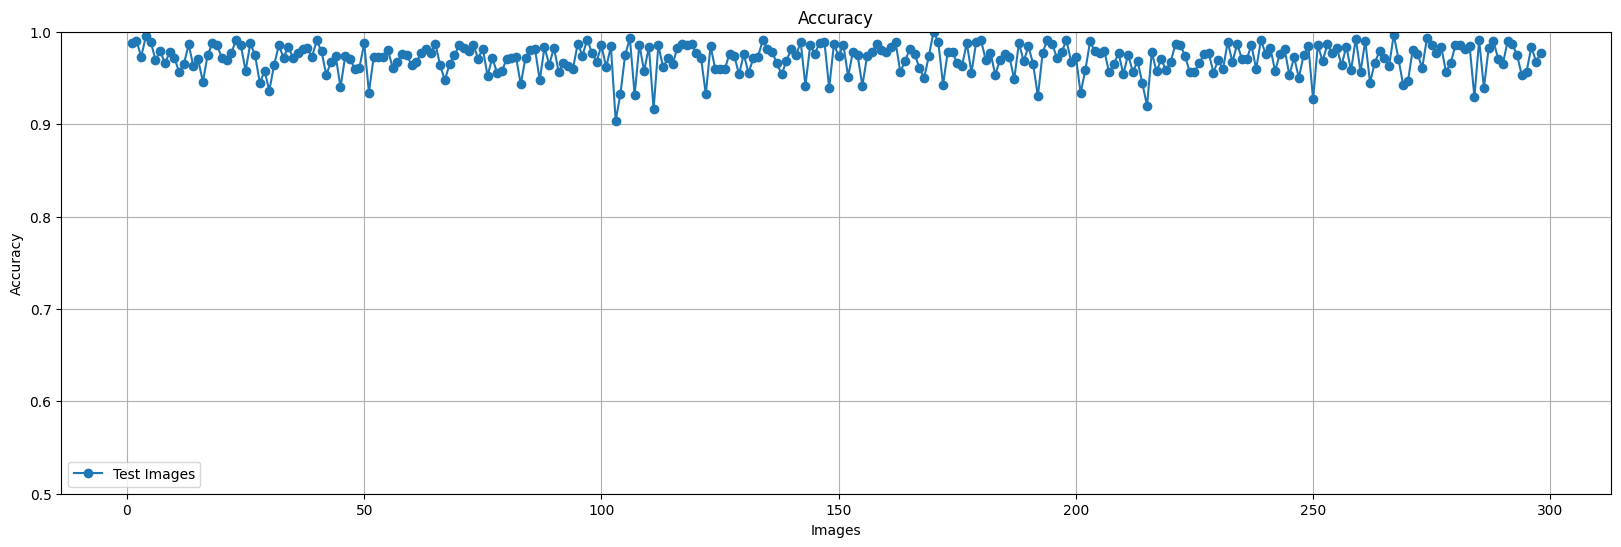

In [ ]:
plot_accuracy(testset,test_accuracy_list,'Test Images')

In [ ]:
# plot_accuracy(trainset,train_accuracy_list,'Train Images')

In [ ]:
# plot_accuracy(validset,val_accuracy_list,'Val Images')

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
def get_cm_etc(mask,pred_mask):
  mask = mask.cpu().view(-1).numpy()
  pred_mask = pred_mask.cpu().view(-1).numpy()

  cm = confusion_matrix(mask, pred_mask, labels=[0, 1])

  precision = precision_score(mask, pred_mask)
  recall = recall_score(mask, pred_mask)
  f1 = f1_score(mask, pred_mask)

  return cm,precision,recall,f1

In [ ]:
def get_cm_etc_list(testset):
  cm_list=[]
  precision_list=[]
  recall_list=[]
  f1_list=[]

  for index in range(len(testset)):
    image,mask = testset[index]
    logits_mask = model(image.to(DEVICE).unsqueeze(0))

    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) * 1.0

    # show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

    a,b,c,d=get_cm_etc(mask,pred_mask)
    cm_list.append(a)
    precision_list.append(b)
    recall_list.append(c)
    f1_list.append(d)

  return cm_list,precision_list,recall_list,f1_list

In [ ]:
cm,precision,recall,f1=get_cm_etc_list(testset)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precis

In [ ]:
def plot_accuracy(dataset,datalist,name):
  ylist = [i for i in range(1, len(dataset) + 1)]

  plt.figure(figsize=(20, 6))
  plt.plot(ylist, datalist, marker='o')
  plt.ylim(0, 1)
  plt.title(name)
  plt.xlabel('Images')
  plt.ylabel(name)
  plt.legend()
  plt.grid(True)
  plt.show()

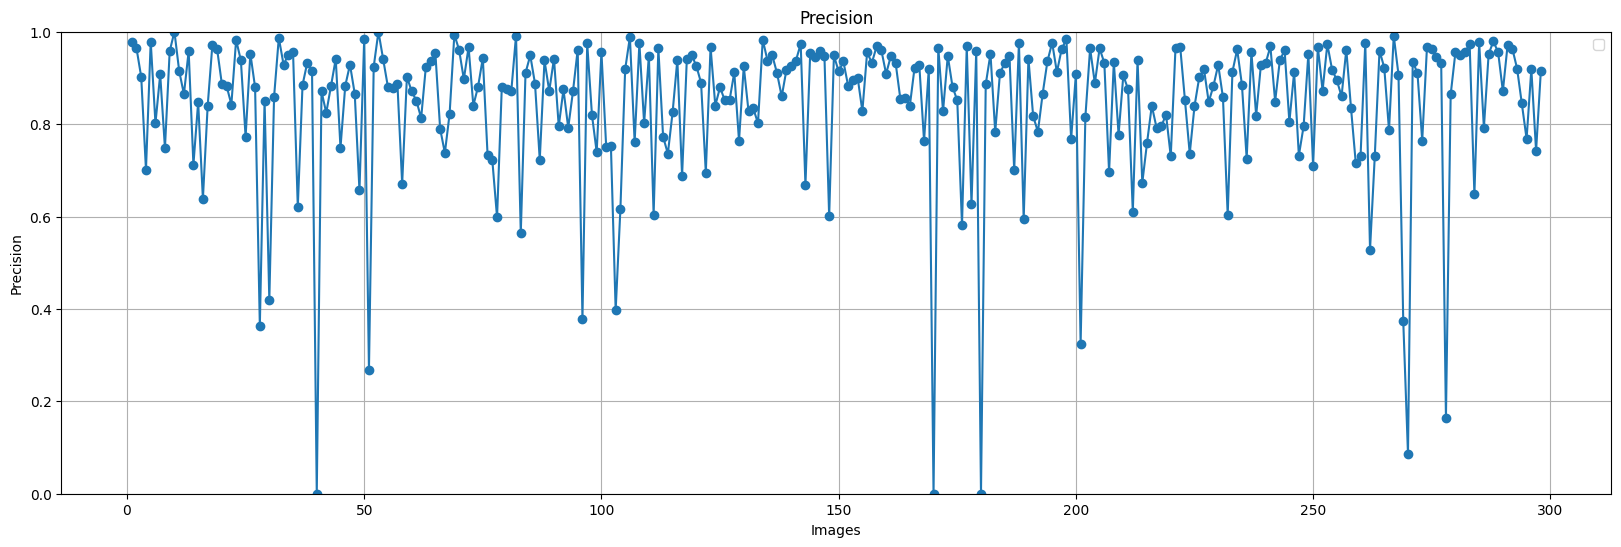

In [ ]:
plot_accuracy(testset,precision,'Precision')

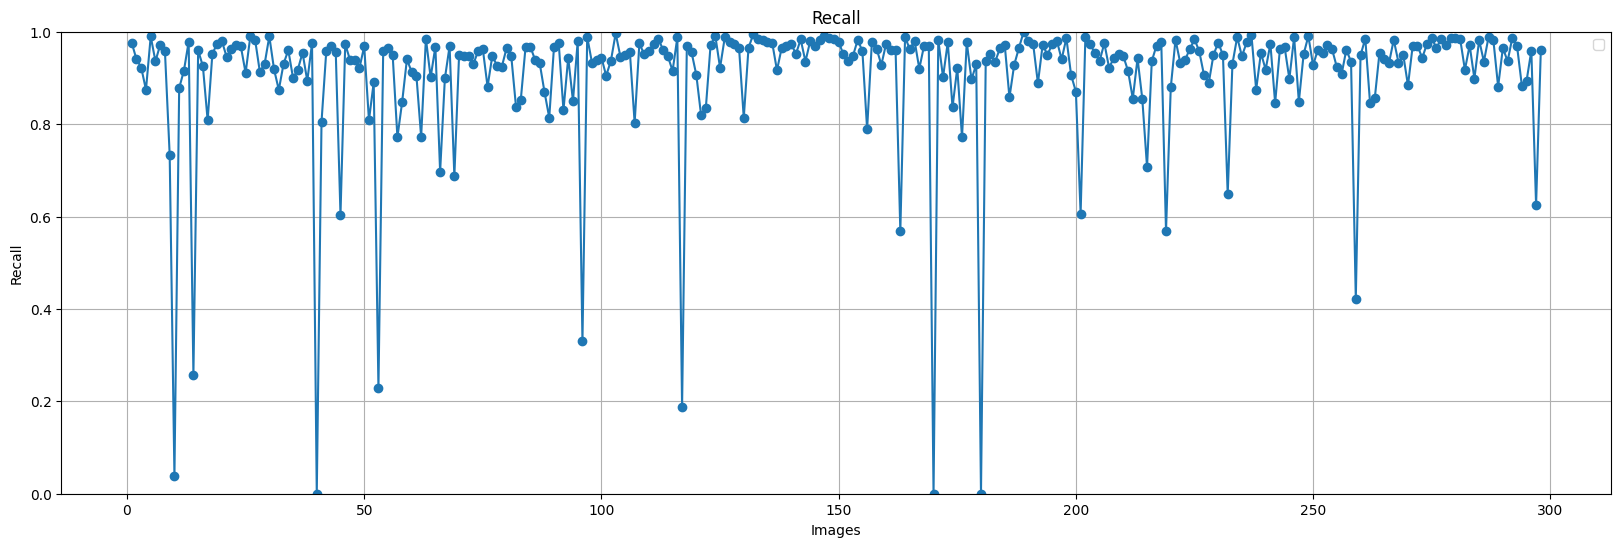

In [ ]:
plot_accuracy(testset,recall,'Recall') #eps pdf

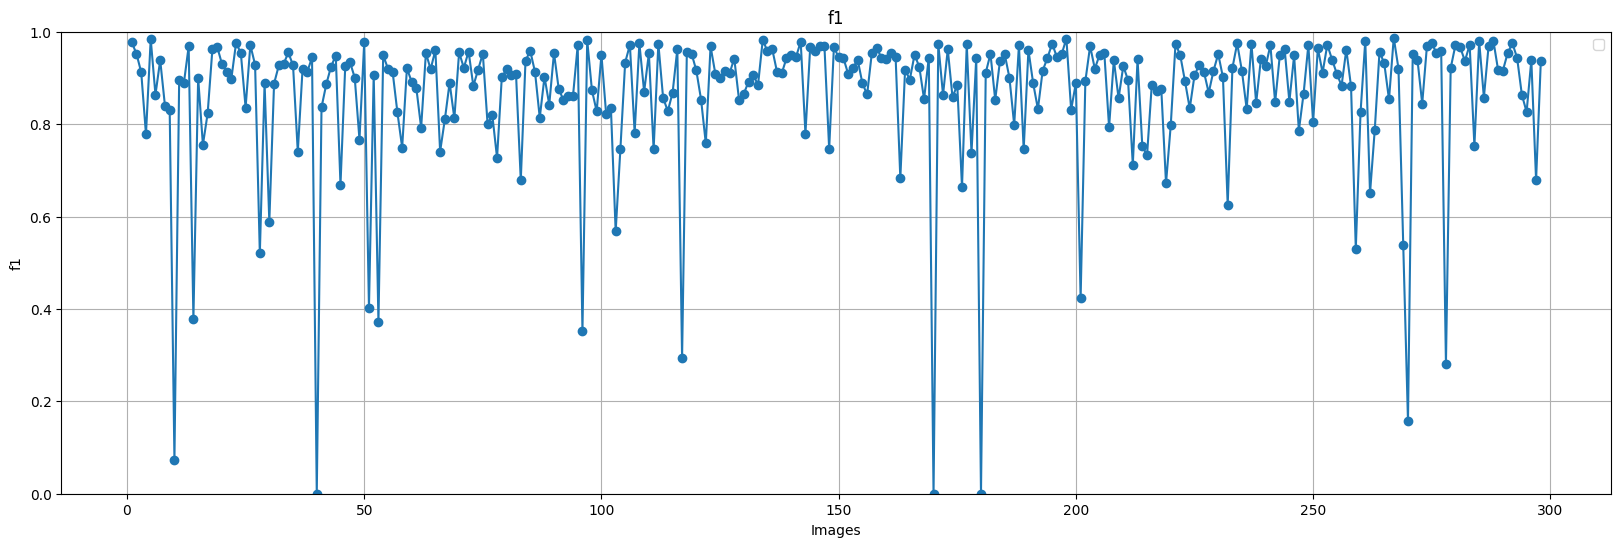

In [ ]:
plot_accuracy(testset,f1,'f1')

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [ ]:
testset

In [ ]:
def get_pred(image,mask,threshold):
  logits_mask = model(image.to(DEVICE).unsqueeze(0))
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask > threshold) * 1.0
  mask_flat =  mask.cpu().view(-1).numpy()
  pred_mask_flat = pred_mask.cpu().view(-1).numpy()
  cm = confusion_matrix(mask_flat, pred_mask_flat)

  TP = cm[1, 1]
  FN = cm[1, 0]
  FP = cm[0, 1]
  TN = cm[0, 0]

  TPR = TP / (TP + FN)
  FPR = FP / (FP + TN)
  return TPR,FPR

In [ ]:
def get_cm_etc_list(testset, num_images, threshold):
    tprglo=[0] * len(threshold)
    fprglo=[0] * len(threshold)

    for index in range(min(num_images, len(testset))):
        image, mask = testset[index]

        tprl=[]
        fprl=[]

        for i in threshold:
          tpr,fpr=get_pred(image,mask,i)
          tprl.append(tpr)
          fprl.append(fpr)

        for i in range(len(tprglo)):
          tprglo[i] += tprl[i]

        for i in range(len(fprglo)):
          fprglo[i] += fprl[i]

    tprglo = [x / num_images for x in tprglo]
    fprglo = [x / num_images for x in fprglo]

    return tprglo, fprglo

In [ ]:
threshold=[]
start_value = 0
end_value = 1
step_size = 0.025

tpr_list=[]
fpr_list=[]

current_value = start_value
while current_value <= end_value:
    threshold.append(current_value)
    current_value += step_size
threshold.append(1)

In [ ]:
tpr_list,fpr_list=get_cm_etc_list(testset,50,threshold)

In [ ]:
tpr_list

[1.0,
 0.991161392438224,
 0.9847088353946566,
 0.9794482826928536,
 0.9753838682083779,
 0.9719069941492091,
 0.9688135368028532,
 0.9660169753909186,
 0.9635233477397405,
 0.9610186942080868,
 0.9586796709818336,
 0.9566824702760421,
 0.9546684578479286,
 0.9527936703148745,
 0.9510495816569935,
 0.9494060753954453,
 0.9478408878225519,
 0.9461889560365271,
 0.944584090278663,
 0.9428892605517453,
 0.941250676993377,
 0.939477533867679,
 0.9377414021213296,
 0.9357429436486497,
 0.9337684365059549,
 0.9317580118347677,
 0.9295308010784338,
 0.9270768428767029,
 0.9244531206778801,
 0.9216666038780792,
 0.9182005417505663,
 0.9145193008005896,
 0.9100202023667072,
 0.9048647814787294,
 0.8983648651972851,
 0.8905774438618056,
 0.8802622884996728,
 0.864839246735393,
 0.8391609368319948,
 0.7818794604577759,
 0.0]

In [ ]:
fpr_list

[1.0,
 0.08911467354949436,
 0.0755159274994258,
 0.06893200631219117,
 0.06497410943126193,
 0.06210440195305214,
 0.05989158223409466,
 0.05803857459785036,
 0.056425019046592126,
 0.05502596266437975,
 0.05381990660942679,
 0.052751121525411226,
 0.05178537868358376,
 0.0509387407573336,
 0.05015280739721245,
 0.04941850820113635,
 0.048731362299884076,
 0.04804228723888641,
 0.047387549742922024,
 0.04674869514985915,
 0.04613653007943393,
 0.045515212728169115,
 0.044918796088555986,
 0.044327322866110165,
 0.04370694037660638,
 0.04306307705076883,
 0.0423647581219456,
 0.04164892770599092,
 0.04090285197096691,
 0.04008958354659153,
 0.03920327050933099,
 0.038228989061310156,
 0.037184765322193815,
 0.03602146702372881,
 0.03464384258964035,
 0.033010399608425056,
 0.031056047790499655,
 0.028587388188856522,
 0.02520001227284388,
 0.02013101530509466,
 0.0]

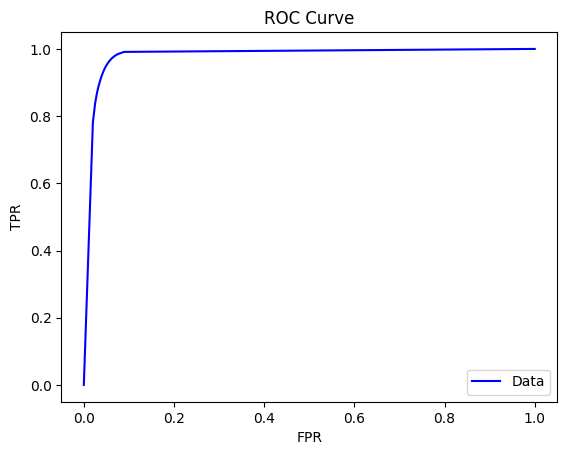

In [ ]:
plt.plot(fpr_list, tpr_list, linestyle='-', color='b', label='Data')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
roc_auc = auc(fpr_list, tpr_list)
print("AUC:", roc_auc)

AUC: 0.9795293278617334


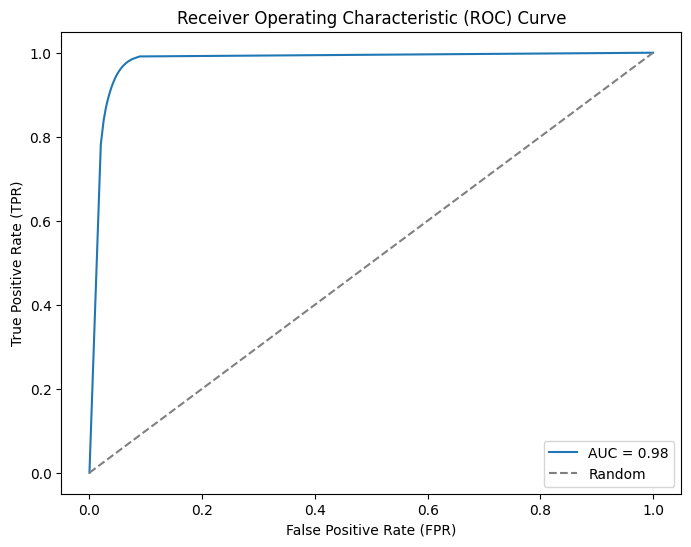

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_list, tpr_list, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()